In [12]:
%matplotlib inline

In [13]:
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import re

import torch
import numpy as np

from IPython.display import display, Image

import pandas as pd

In [14]:
from output_utils import *

In [15]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
pathpattern = 'Laborieux-Arch/results/*/*/*/*/'
runs = getruns(pathpattern=pathpattern)

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
runsdf = pd.DataFrame(runs)
runsdf.sort_values('dir', ascending=False)[runsdf['noise'] > 0][['loss', 'noise', 'train', 'test', 'epoch', 'dir', 'load_path_convert']]

/vast/home/rstrauss/.conda/envs/EP/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,loss,noise,train,test,epoch,dir,load_path_convert


In [21]:
msepath = './Laborieux-Arch/results/EP/mse/2023-08-03/orig_mse_14-38-36_gpu0_120epochs/'
# latpath = './Laborieux-Arch/results/EP/mse/2023-07-30/featip_21-04-42_gpu0_120epochs/' # lateral feature inner product inhibition
# latpath = './Laborieux-Arch/results/EP/mse/2023-08-15/17-45-32_gpu0' # trained lat all-to-all
# lat2path = './Laborieux-Arch/results/EP/cel/2023-08-15/20-15-37_gpu0' # cel version, only 2 lat layers
celpath = './Laborieux-Arch/results/EP/cel/2023-07-29/origcode_11-01-25_gpu0_120epochs/'
noise005path = './Laborieux-Arch/results/EP/mse/2023-08-22/11-05-29_gpu0/'
noise01path = './Laborieux-Arch/results/EP/mse/2023-08-22/11-05-32_gpu0/'
noise03path = './Laborieux-Arch/results/EP/mse/2023-08-22/11-05-35_gpu0/'

noisecel005path = './Laborieux-Arch/results/EP/cel/2023-08-22/13-40-18_gpu0'

noisecel01path = './Laborieux-Arch/results/EP/cel/2023-08-22/21-15-43_gpu0'
noisecel03path = './Laborieux-Arch/results/EP/cel/2023-08-25/11-14-07_gpu0'

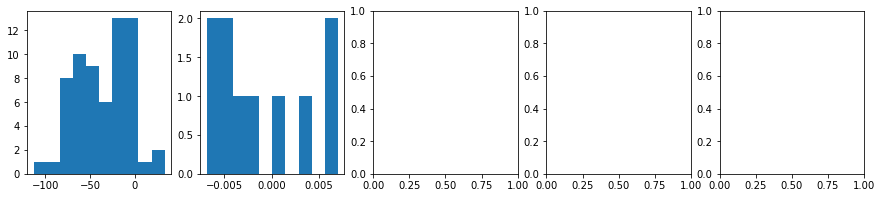

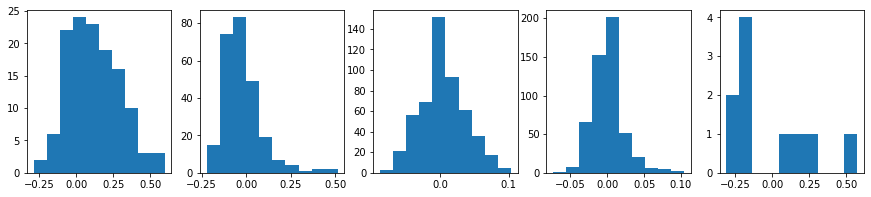

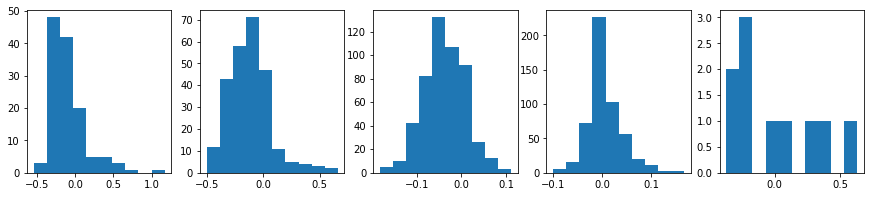

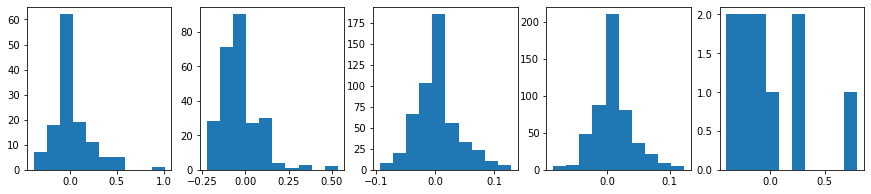

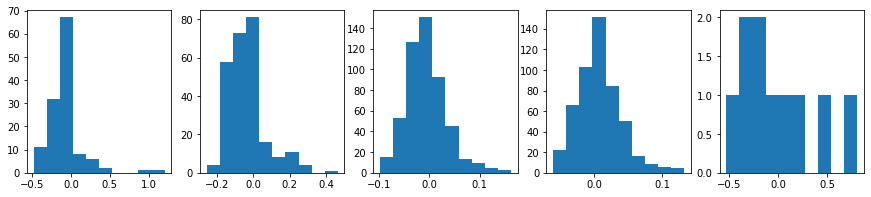

In [22]:
for path in ['./Laborieux-Arch/results/EP/mse/2023-08-30/11-48-30_gpu1', celpath, noisecel005path, noisecel01path, noisecel03path]:
    model = torch.load(path + '/model.pt', map_location=torch.device('cpu'))
    # msemodel = torch.load('Laborieux-Arch/results/EP/mse/2023-08-22/11-05-29_gpu0/model.pt', map_location=torch.device('cpu'))

    fig, axs = plt.subplots(1, 5, figsize=(15,3))

    for idx in range(len(model.synapses)):
        # freqs, bins = torch.histogram(model.synapses[idx].bias, bins=10)
        # axs[idx].bar(bins[:-1].data.cpu(), freqs.data.cpu(), align='edge')
        axs[idx].hist(model.synapses[idx].bias.data.numpy().flatten())
        # axs[idx].set_xlim(-1,1)
    plt.show()

In [23]:
mseacc = np.load(msepath + '/PGD_attack/attacked_accuracy.npy')
# latacc = np.load(latpath + '/PGD_attack/attacked_accuracy.npy')
# lat2acc = np.load(lat2path + '/PGD_attack/attacked_accuracy.npy')
celacc = np.load(celpath + '/PGD_attack/attacked_accuracy.npy')
noise005acc = np.load(noise005path + '/PGD_attack/attacked_accuracy.npy')
noise01acc = np.load(noise01path + '/PGD_attack/attacked_accuracy.npy')
noise03acc = np.load(noise03path + '/PGD_attack/attacked_accuracy.npy')

# fine-tuned
noisecel005acc = np.load(noisecel005path + '/PGD_attack/attacked_accuracy.npy')
# full-length trained
noisecel01acc = np.load(noisecel01path + '/PGD_attack/attacked_accuracy.npy')
noisecel03acc = np.load(noisecel03path + '/PGD_attack/attacked_accuracy.npy')


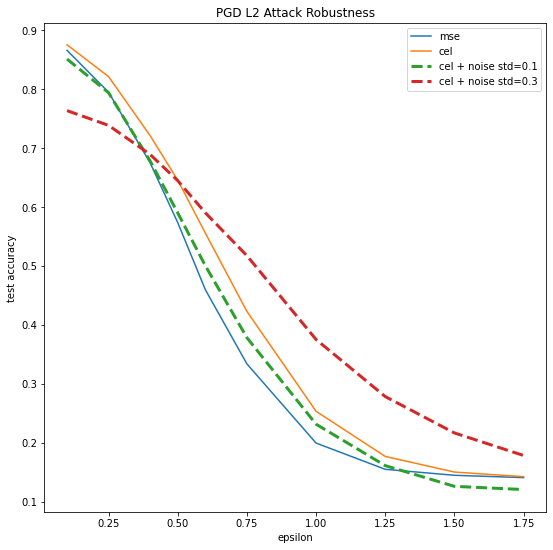

In [24]:
plt.figure(figsize=(9,9))

plt.plot(*mseacc, label='mse')
# plt.plot(*latacc, label='lateral trained (mse)')
# plt.plot(*lat2acc, label='lateral trained (cel)')
plt.plot(*celacc, label='cel')
# plt.plot(*noise005acc, label='mse + std=0.05 noise', linestyle='--', linewidth=3)
# plt.plot(*noise01acc, label='mse + noise std=0.1 ', linestyle='--', linewidth=3)
# plt.plot(*noise03acc, label='mse + noise std=0.3', linestyle='--', linewidth=3)
# plt.plot(*noisecel005acc, label='cel + std=0.05 noise', linestyle='--', linewidth=3)
plt.plot(*noisecel01acc, label='cel + noise std=0.1', linestyle='--', linewidth=3)
plt.plot(*noisecel03acc, label='cel + noise std=0.3', linestyle='--', linewidth=3)

plt.title('PGD L2 Attack Robustness')
plt.xlabel('epsilon')
plt.ylabel('test accuracy')
plt.legend()

plt.savefig('PGD_Robustness_MSE_vs_CEL_vs_LatSoft.pdf', bbox_inches='tight')

In [25]:
def showattacks(attackx, x, attackpreds, origpreds, savefig=False, path='/tmp/attack.pdf'):
    fig, axs = plt.subplots(3, len(attackx), figsize=(3*len(attackx),3*3))
    axs[0,0].set_ylabel("original")
    for idx in range(len(attackx)):
        axs[0,idx].imshow(x[idx].transpose(1,2,0))#/2 + 0.5)
        axs[0,idx].set_title(str(origpreds[idx]))
        axs[0,idx].set_xticks([])
        axs[0,idx].set_yticks([])

    axs[1,0].set_ylabel("attacked")
    for idx in range(len(attackx)):
        axs[1,idx].imshow(attackx[idx].transpose(1,2,0))#/2 + 0.5)
        axs[1,idx].set_title(str(attackpreds[idx]))
        axs[1,idx].set_xticks([])
        axs[1,idx].set_yticks([])

    axs[2,0].set_ylabel("diff")
    for idx in range(len(attackx)):
        diff = attackx[idx].transpose(1,2,0) - x[idx].transpose(1,2,0)
        diff -= np.min(diff)
        diff = diff / np.max(diff)
        axs[2,idx].imshow(diff)
        axs[2,idx].set_xticks([])
        axs[2,idx].set_yticks([])

    plt.tight_layout()
    
    return fig, axs

def showexamples(path, eps, num=10):
    examples = np.load(path + '/PGD_attack/adversarial_examples/eps_{}/attack_15__pred_250__examples.npy'.format(eps), allow_pickle=True)
    att_pred = np.load(path + '/PGD_attack/adversarial_examples/eps_{}/attack_15__pred_250__attacked_pred.npy'.format(eps), allow_pickle=True)
    originals = np.load(path + '/PGD_attack/adversarial_examples/eps_{}/attack_15__pred_250__originals.npy'.format(eps), allow_pickle=True)
    labels = np.load(path + '/PGD_attack/adversarial_examples/eps_{}/attack_15__pred_250__original_pred.npy'.format(eps), allow_pickle=True)
    
    return showattacks(examples[-1][:num], originals[-1][:num], att_pred[-1][:num], labels[-1][:num])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

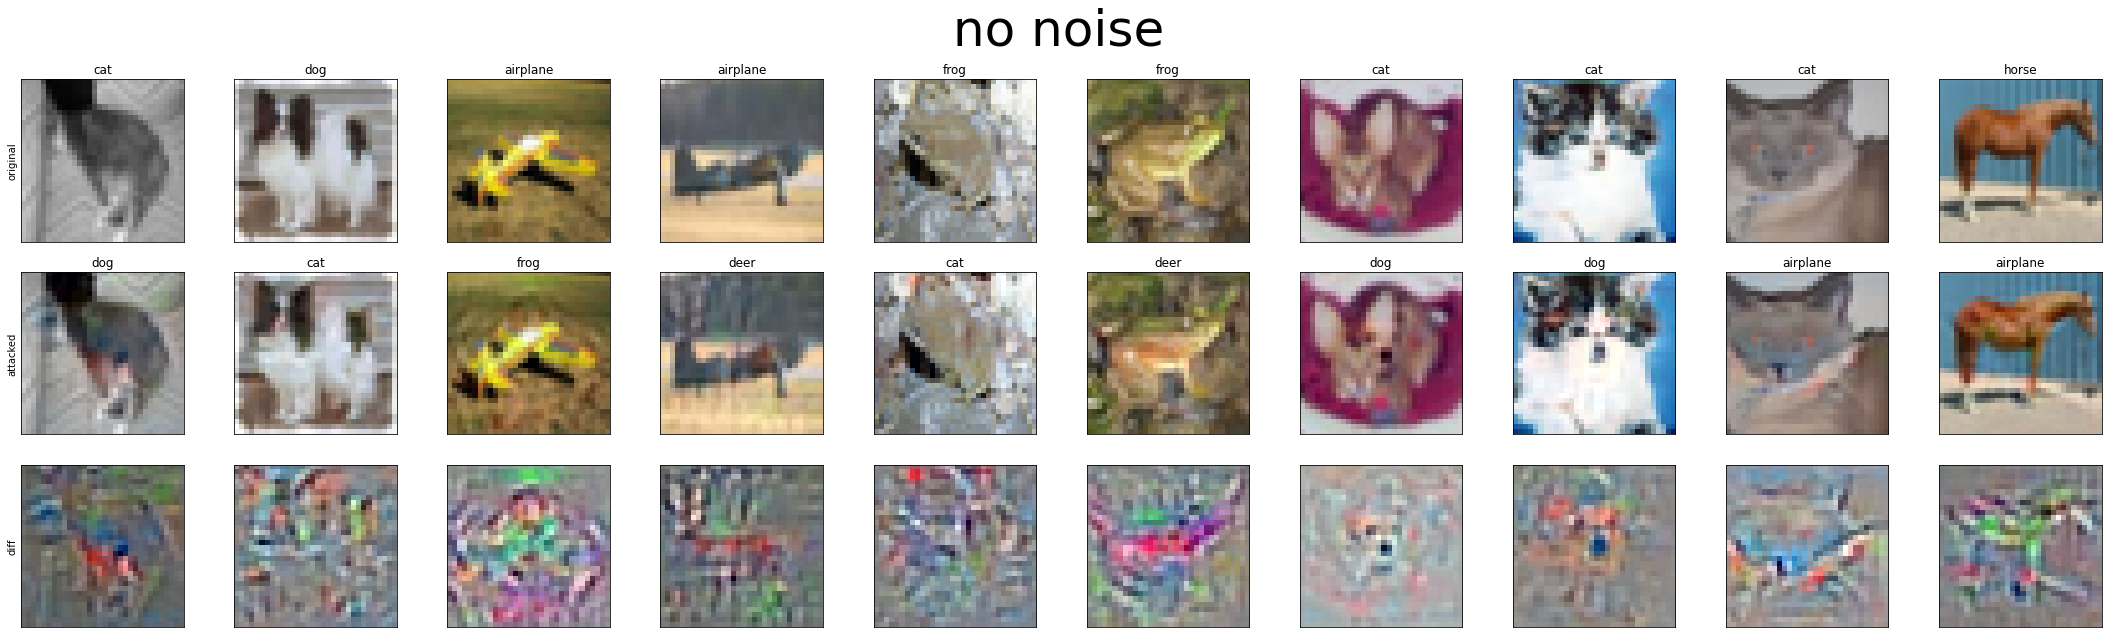

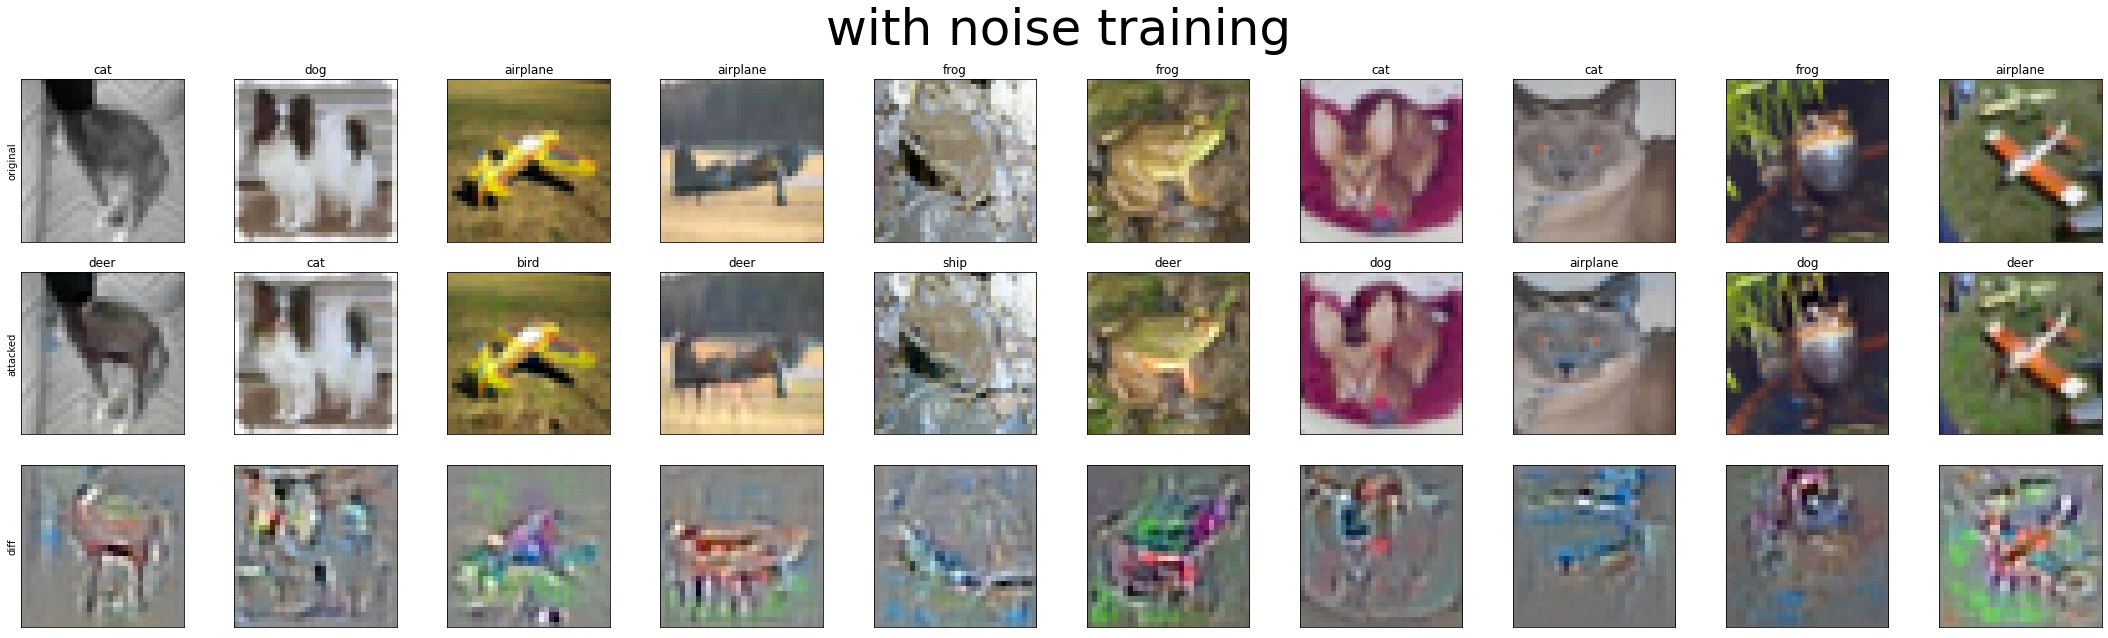

In [35]:
eps = 1.75
showexamples(noisecel01path, eps)[0].suptitle('no noise', fontsize=50)
plt.tight_layout()
showexamples(noise03path, eps)[0].suptitle('with noise training', fontsize=50)
plt.tight_layout()

In [47]:
import torchvision

In [52]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


               

In [128]:
def getbatch(noise=0.3, num=10, mbs=128):
    transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(0.5),
                                                              torchvision.transforms.RandomCrop(size=[32,32], padding=4, padding_mode='edge'),
                                                              torchvision.transforms.ToTensor(),
                                                              torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                                                                               std=(3*0.2023, 3*0.1994, 3*0.2010)) ])
    transform_train = torchvision.transforms.Compose([transform_train, AddGaussianNoise(0.0, noise)])
    cifar10_train_dset = torchvision.datasets.CIFAR10('./cifar10_pytorch', train=True, transform=transform_train, download=True)
    # cifar10_test_dset = torchvision.datasets.CIFAR10('./cifar10_pytorch', train=False, transform=transform_test, download=True)

    # For Validation set
    # val_index = np.random.randint(10)
    # val_samples = list(range( 5000 * val_index, 5000 * (val_index + 1) ))

    #train_loader = torch.utils.data.DataLoader(cifar10_train_dset, batch_size=mbs, sampler = torch.utils.data.SubsetRandomSampler(val_samples), shuffle=False, num_workers=1)
    train_loader = torch.utils.data.DataLoader(cifar10_train_dset, batch_size=mbs, shuffle=True, num_workers=1)
    # test_loader = torch.utils.data.DataLoader(cifar10_test_dset, batch_size=args.mbs_test, shuffle=False, num_workers=1)
    xy = next(iter(train_loader))
    return xy[0], list(map(lambda i: train_loader.dataset.classes[i], xy[1]))

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

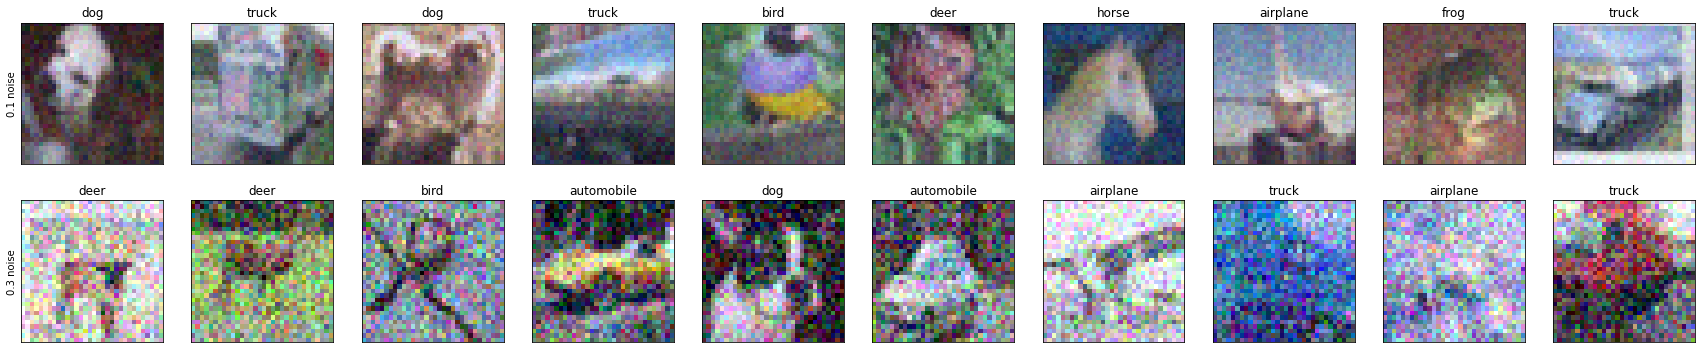

In [131]:
batch01, y01 = getbatch(0.1)
batch03, y03 = getbatch(0.3)

fig, axs = plt.subplots(2, num, figsize=(3*num,3*2))
axs[0,0].set_ylabel("0.1 noise")
for idx in range(num):
    axs[0,idx].imshow(batch01[idx].numpy().transpose(1,2,0)*0.5 + 0.5)#/2 + 0.5)
    axs[0,idx].set_title(str(y01[idx]))
    axs[0,idx].set_xticks([])
    axs[0,idx].set_yticks([])

axs[1,0].set_ylabel("0.3 noise")
for idx in range(num):
    axs[1,idx].imshow(batch03[idx].numpy().transpose(1,2,0)*0.5 + 0.5)#/2 + 0.5)
    axs[1,idx].set_title(str(y03[idx]))
    axs[1,idx].set_xticks([])
    axs[1,idx].set_yticks([])

(array([  608., 15942., 52767., 75690., 81263., 72507., 48505., 30249.,
        14746.,   939.]),
 array([-1.1388792 , -0.89969254, -0.6605059 , -0.42131922, -0.18213256,
         0.0570541 ,  0.29624075,  0.5354274 ,  0.7746141 ,  1.0138007 ,
         1.2529874 ], dtype=float32),
 <BarContainer object of 10 artists>)

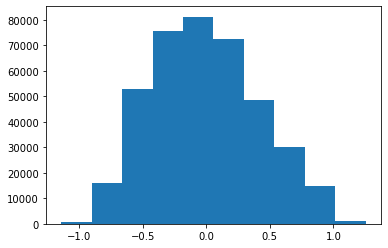

In [133]:
plt.hist(batch01.numpy().flatten())

In [72]:
### fucntionalize main.py, so i can import and call it (also import the parser for output_utils)

#import subprocess

#subprocess.run(['python', 'main.py', '--task CIFAR10', '--noise 0.1', '--epochs 0'], capture_output=True).stdout.decode

In [ ]:
## anneal in the noise, at least have some examples with less noise variance. Perhaps this is why it underperforms on test- not enough noise

In [174]:
from model_utils import *

In [ ]:
model = torch.load('Laborieux-Arch/results/LCA/mse/2023-09-17/18-19-28_gpu1/model.pt', map_location=torch.device('cpu'))

In [172]:
model.dt = 0.5

In [202]:
targetneurons = [batch01, torch.tensor([]), torch.tensor([]), torch.tensor([]), torch.tensor([]), torch.tensor([]), torch.tensor([])]
betas = betas=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [210]:
neurons = model.init_neurons(128, torch.device('cpu'))

In [213]:
neurons = model.forward(batch01, torch.zeros(128), neurons, 10, beta=1.0)
neurons_2 = copy(neurons)

In [ ]:
model = torch.load('Laborieux-Arch/results/EP/mse/2023-08-30/11-48-30_gpu1/model.pt', map_location=torch.device('cpu'))

In [ ]:
model.inputbeta

In [18]:
pathpattern = 'Laborieux-Arch/results/*/*/*/*/'
runs = getruns(pathpattern=pathpattern)

In [ ]:
runsdf = pd.DataFrame(runs)
runsdf.sort_values('dir', ascending=False)[runsdf['model'] == 'autoLCACNN'][['epoch', 'T1', 'T2', 'lrs', 'dir']]

In [7]:
mymodel = torch.load('./Laborieux-Arch/results/LCA/mse/2023-09-17/21-21-43_gpu1/model.pt', map_location=torch.device('cpu'))

In [8]:
#mymodel = torch.load('./Laborieux-Arch/results/LCA/mse/2023-09-17/20-53-06_gpu1/model.pt', map_location=torch.device('cpu'))

In [63]:
sparsecoding = torch.load('./Laborieux-Arch/results/LCA/mse/2023-09-18/13-42-32_gpu0/model.pt', map_location=torch.device('cpu'))

In [82]:
sparsecoding = torch.load('./Laborieux-Arch/results/LCA/mse/2023-09-18/14-09-40_gpu0/model.pt', map_location=torch.device('cpu'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


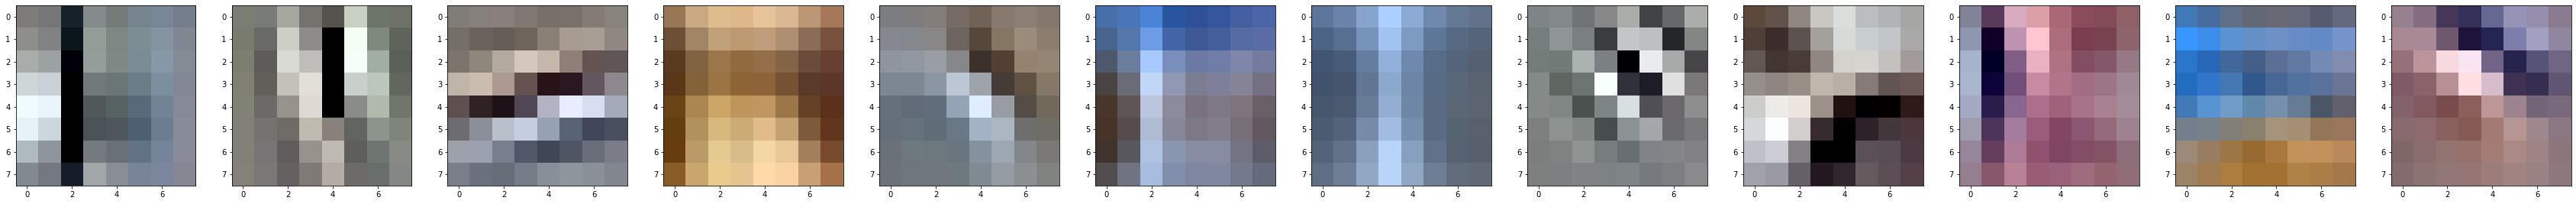

In [16]:
model = mymodel    
fig, axs = plt.subplots(1, 12, figsize=(60, 5))

for idx in range(12):
    feature = model.synapses[0].weight[idx,:,:,:].data.numpy().transpose(1,2,0)
    # feature -= np.min(feature)
    # feature /= np.max(feature)
    # print(feature)
    axs[idx].imshow(feature/np.max(feature)/2 + 0.5)

In [17]:
def montage(X):
    m, n, count = np.shape(X)
    mm = int(np.ceil(np.sqrt(count)))
    nn = mm
    M = np.zeros((mm * m, nn * n))

    image_id = 0
    for j in range(mm):
        for k in range(nn):
            if image_id >= count:
                break
            sliceM, sliceN = j * m, k * n
            M[sliceN:sliceN + n, sliceM:sliceM + m] = X[:, :, image_id]
            image_id += 1
    return M

In [22]:
featm = np.asarray([montage(mymodel.synapses[0].weight.transpose(0,2).transpose(1,3)[:,:,:,i].data.numpy()) for i in range(3)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


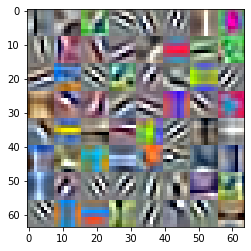

In [23]:
plt.imshow(featm.transpose(1,2,0)*3+ 0.5)

In [83]:
featm2 = np.asarray([montage(sparsecoding.synapses[0].weight.transpose(0,2).transpose(1,3)[:,:,:,i].data.numpy()) for i in range(3)])

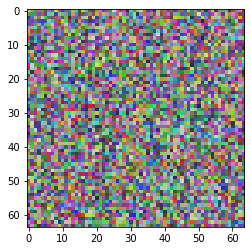

In [84]:
plt.imshow(featm2.transpose(1,2,0)*3 + 0.5)

In [52]:
np.sum(featm**2)

63.999878957214214

In [53]:
np.sum(featm2**2)

61.60149316946305

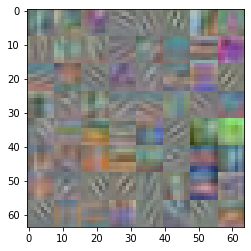

In [56]:
plt.imshow((featm-featm2).transpose(1,2,0)*3 +0.5)

In [ ]:
plt.hist(mymodel.synapses[0].weight.flatten().detach().numpy(), bins=100)

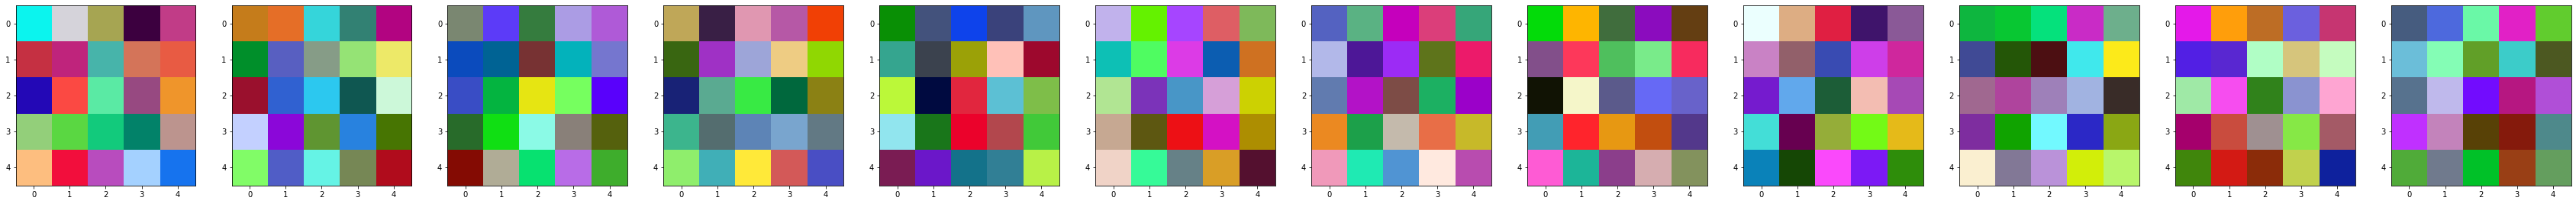

In [68]:
model = sparsecoding    
fig, axs = plt.subplots(1, 12, figsize=(60, 5))

for idx in range(12):
    feature = model.synapses[0].weight[idx,:,:,:].data.numpy().transpose(1,2,0)
    feature -= np.min(feature)
    feature /= np.max(feature)
    # print(feature)
    axs[idx].imshow(feature)

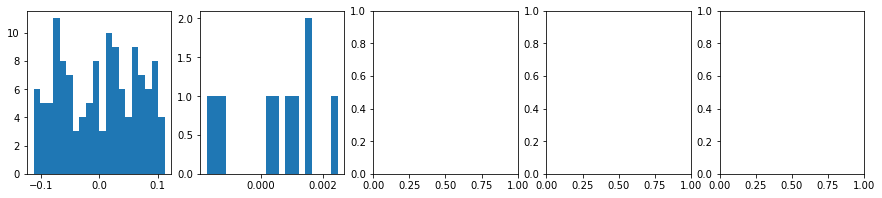

In [72]:
fig, axs = plt.subplots(1, 5, figsize=(15,3))

for idx in range(len(model.synapses)):
    freqs, bins = torch.histogram(model.synapses[idx].bias, bins=20)
    axs[idx].bar(bins[:-1].data.cpu(), freqs.data.cpu(), align='edge', width=(bins[1]-bins[0]).detach().numpy())    

In [73]:
model = mymodel

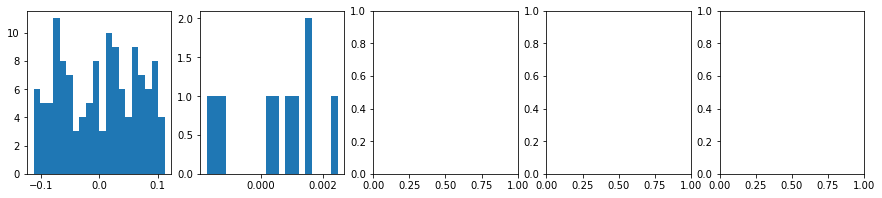

In [74]:
fig, axs = plt.subplots(1, 5, figsize=(15,3))

for idx in range(len(model.synapses)):
    freqs, bins = torch.histogram(model.synapses[idx].bias, bins=20)
    axs[idx].bar(bins[:-1].data.cpu(), freqs.data.cpu(), align='edge', width=(bins[1]-bins[0]).detach().numpy())    